In [207]:
import os
import pandas as pd
import numpy as np
import pymc3 as pm
from sklearn.metrics import log_loss, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [135]:
base_dir = os.path.join("/Users", "sbussmann", "Development", "buda", "buda-ratings")
interim_dir = os.path.join(base_dir, 'data', 'interim')

In [136]:
league_id = 40264
winloss = pd.read_csv(os.path.join(interim_dir, "winloss_divprior_{}.csv".format(league_id)))

In [137]:
winloss.head()

Team A             Team B  Team A Wins  Index A  Index B      Div A  \
0   AHOC          Gothrilla         True        0        1  4/3 Div 1   
1   AHOC                BBN         True        0        9  4/3 Div 1   
2   AHOC       Stonecutters         True        0       41  4/3 Div 1   
3   AHOC          FlowChart         True        0        2  4/3 Div 1   
4   AHOC  Lady and the BAMF         True        0       28  4/3 Div 1   

       Div B  
0  4/3 Div 1  
1  4/3 Div 1  
2  5/2 Div 1  
3  4/3 Div 1  
4  4/3 Div 2

In [138]:
winloss.shape

(522, 7)

In [139]:
teams = set(np.append(winloss['Team A'].unique(), winloss['Team B'].unique()))

In [140]:
rating_prior_div = {
    '4/3 Div 1': 3.0,
    '4/3 Div 2': 0.0,
    '4/3 Div 3': -1.0,
    '5/2 Div 1': 3.0,
    '5/2 Div 2': 0.0,
    '5/2 Div 3': -1.0
}
alphas = []
for i in range(len(teams)):
    if i in winloss['Index A'].values:
        index = winloss['Index A'] == i
        div = winloss.loc[index, 'Div A'].unique()[0]
        alpha = rating_prior_div[div]
        alphas.append(alpha)
    else:
        index = winloss['Index B'] == i
        div = winloss.loc[index, 'Div B'].unique()[0]
        alpha = rating_prior_div[div]
        alphas.append(alpha)

In [141]:
team1 = winloss['Index A'].values
team2 = winloss['Index B'].values

with pm.Model() as model:
    
#     sharpness = pm.HalfStudentT('sharpness', sd=2.5, nu=3)
    ratings = pm.Normal('ratings', mu=alphas, shape=len(teams))
    
    logit = ratings[team1] - ratings[team2]

    p = 1 / (1 + np.exp(-logit))
    win = pm.Bernoulli('win', p, observed=winloss['Team A Wins'].values)

In [142]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ratings]
100%|██████████| 1500/1500 [00:03<00:00, 465.37it/s]


In [143]:
# meanratings = trace.get_values('ratings').mean(axis=0)
meanratings = np.percentile(trace.get_values('ratings'), 50, axis=0)

In [133]:
pm.traceplot(trace, varnames=['sharpness'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c17d3a290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c17d4dfd0>]], dtype=object)

In [47]:
1/(1 + np.exp(-1.4 * 0.2))

0.56954622393922905

In [144]:
names = []
for i, meanrating in enumerate(meanratings):
    if i in winloss['Index A'].values:
        index = winloss['Index A'] == i
        name = winloss.loc[index, 'Team A'].unique()[0]
    else:
        index = winloss['Index B'] == i
        name = winloss.loc[index, 'Team B'].unique()[0]
    names.append(name)
#     print("{}: {:.3f}".format(name, meanrating))

In [145]:
ratingsdf = pd.DataFrame({
    'mean_rating': meanratings
}, index=names)

In [146]:
ratingsdf.sort_values('mean_rating', ascending=False)

mean_rating
AHOC                                           4.591016
SnakeCountryBromance                           4.020639
Zerg Rush!                                     3.394886
Gothrilla                                      3.321160
FlowChart                                      3.142383
Stonecutters                                   2.886318
GrassBurner                                    2.377475
Injustice League                               2.262966
Swingers                                       2.154912
TuneSquad                                      2.009433
Puddingstone                                   1.804154
Upstream                                       1.743924
Turtle Boy                                     1.728587
Pink Flamingos                                 1.712580
Jack's Abby HAOS Lager                         1.698585
Maverick                                       1.684826
JuJu Hex                                       1.583524
BBN                                            1.538280
Shake and Bake                                 1.510179
Live Poultry, Fresh Killed (LPFK)              1.260373
Baba Yaga                                      1.163368
License to Kilt (fka Scoobers in Scotland)     0.985680
Rubs The Duckie                                0.818137
Flaming Croissants                             0.762267
Hippos                                         0.714121
Bacon                                          0.656580
Hucky McThrowandcatch                          0.625559
JHOP                                           0.587188
Toads                                          0.428235
SHRedline                                      0.348285
...                                                 ...
Fetch                                         -0.063540
Flying Salsa                                  -0.202460
Moose Lightning                               -0.235958
The Funky Bunch                               -0.251637
Oddjob                                        -0.273340
A Lil Bit Sticky                              -0.278289
Granite State Grass Stains                    -0.428942
Nerd Alert                                    -0.487989
Rabbit Disc                                   -0.720299
Demons                                        -0.897882
Lady and the BAMF                             -0.940482
Iron Squids                                   -1.078027
Alpha No Beta                                 -1.091383
Baboon Heart                                  -1.122081
Stack to the Future                           -1.150254
Spam                                          -1.247817
Batman and the Robins                         -1.322310
Hipster Kitties                               -1.337537
Tofu Wolf                                     -1.348746
Tubbs                                         -1.452570
Underwater Monkey Cowboys                     -1.468969
SIR!                                          -1.634651
Top Shelf                                     -1.680645
Jiggy                                         -1.967288
M.O.B.                                        -2.059454
TuneSquad Squared                             -2.146473
Killer Bees                                   -2.274087
123 Trap!                                     -2.334138
THEM!                                         -2.463396
Spawning Alewives                             -2.690234

[67 rows x 1 columns]

In [147]:
plusminus = pd.read_csv(os.path.join(interim_dir, 'plusminus_{}.csv'.format(league_id)), index_col='Team Name')

In [148]:
totaldf = plusminus.join(ratingsdf, how='inner')

In [149]:
totaldf.groupby('divname').mean()

PlusMinus      Wins     Losses      Ties  mean_rating
divname                                                         
4/3 Div 1  11.400000  8.300000   6.500000  0.600000     2.551850
4/3 Div 2   2.727273  9.136364   8.818182  0.090909     0.220013
4/3 Div 3 -14.375000  6.625000   7.625000  0.125000    -1.142713
5/2 Div 1   7.666667  5.333333   3.666667  1.333333     2.805712
5/2 Div 2  17.818182  7.363636   4.909091  0.181818     0.665212
5/2 Div 3 -22.076923  6.307692  10.153846  0.076923    -1.463587

In [150]:
totaldf.sort_values('mean_rating', ascending=False)

PlusMinus    divname  Wins  \
AHOC                                              100  4/3 Div 1    14   
SnakeCountryBromance                               33  5/2 Div 1     5   
Zerg Rush!                                         22  4/3 Div 1    10   
Gothrilla                                          47  4/3 Div 1    12   
FlowChart                                          29  4/3 Div 1    12   
Stonecutters                                       24  5/2 Div 1     8   
GrassBurner                                        29  4/3 Div 1    11   
Injustice League                                  100  4/3 Div 2    14   
Swingers                                           -6  4/3 Div 1     5   
TuneSquad                                          -9  4/3 Div 1     6   
Puddingstone                                       98  4/3 Div 2    18   
Upstream                                          119  4/3 Div 2    20   
Turtle Boy                                        -12  4/3 Div 1     5   
Pink Flamingos                                     58  5/2 Div 2    10   
Jack's Abby HAOS Lager                             46  4/3 Div 2    10   
Maverick                                           42  5/2 Div 2     9   
JuJu Hex                                           72  5/2 Div 2    11   
BBN                                               -47  4/3 Div 1     2   
Shake and Bake                                    -34  5/2 Div 1     3   
Live Poultry, Fresh Killed (LPFK)                 -39  4/3 Div 1     6   
Baba Yaga                                          47  5/2 Div 2     9   
License to Kilt (fka Scoobers in Scotland)         46  4/3 Div 2    13   
Rubs The Duckie                                    30  4/3 Div 2     9   
Flaming Croissants                                 66  4/3 Div 2    15   
Hippos                                             26  5/2 Div 2     9   
Bacon                                              18  5/2 Div 2     7   
Hucky McThrowandcatch                              -1  5/2 Div 2     5   
JHOP                                               32  4/3 Div 2    12   
Toads                                              40  4/3 Div 2    15   
SHRedline                                          -6  5/2 Div 2     6   
...                                               ...        ...   ...   
Fetch                                               9  4/3 Div 2     8   
Flying Salsa                                       13  5/2 Div 3    12   
Moose Lightning                                   -65  4/3 Div 2     4   
The Funky Bunch                                   -29  5/2 Div 2     4   
Oddjob                                             11  4/3 Div 3    13   
A Lil Bit Sticky                                  -43  4/3 Div 2     5   
Granite State Grass Stains                         22  5/2 Div 3     6   
Nerd Alert                                        -54  4/3 Div 2     7   
Rabbit Disc                                        37  5/2 Div 3    12   
Demons                                             12  5/2 Div 3     5   
Lady and the BAMF                                 -74  4/3 Div 2     5   
Iron Squids                                       -33  5/2 Div 2     1   
Alpha No Beta                                      -7  5/2 Div 3    10   
Baboon Heart                                      -35  4/3 Div 3     5   
Stack to the Future                                -7  4/3 Div 3     9   
Spam                                              -36  5/2 Div 3     9   
Batman and the Robins                              -3  4/3 Div 3     6   
Hipster Kitties                                   -98  4/3 Div 2     3   
Tofu Wolf                                         -15  5/2 Div 3    11   
Tubbs                                             -89  4/3 Div 2     2   
Underwater Monkey Cowboys                         -24  4/3 Div 3     6   
SIR!                                              -53  5/2 Div 3     4   
Top Shelf                                       

In [151]:
trace['ratings'].shape

(4000, 67)

In [152]:
def get_index(team_name, df):
    team_index = df.loc[team_name, 'Index']
    
    return team_index

In [173]:
def calc_prob(indexA, indexB, trace):
    
#     sharpness = trace['sharpness']
    deltaRating = trace['ratings'][:, indexA] - trace['ratings'][:, indexB]
    probAWins = 1. / (1 + np.exp(-deltaRating))
    return probAWins.mean()

In [175]:
simprobs = calc_prob(0, 1, trace)

In [176]:
simprobs

0.75570405636040805

In [222]:
winloss_with_dup = pd.read_csv(os.path.join(interim_dir, 'winloss_with_duplicates.csv'))

In [223]:
winloss_with_dup['predicted'] = winloss_with_dup.apply(lambda x: calc_prob(x['Index A'], x['Index B'], trace), axis=1)

In [224]:
winloss_with_dup.head()

Team A             Team B    divname  Team A Wins  Index A  Index B  \
0   AHOC          Gothrilla  4/3 Div 1         True        0        1   
1   AHOC                BBN  4/3 Div 1         True        0        9   
2   AHOC       Stonecutters  4/3 Div 1         True        0       41   
3   AHOC          FlowChart  4/3 Div 1         True        0        2   
4   AHOC  Lady and the BAMF  4/3 Div 1         True        0       28   

       Div A      Div B  predicted  
0  4/3 Div 1  4/3 Div 1   0.755704  
1  4/3 Div 1  4/3 Div 1   0.940152  
2  4/3 Div 1  5/2 Div 1   0.817569  
3  4/3 Div 1  4/3 Div 1   0.779964  
4  4/3 Div 1  4/3 Div 2   0.994420

In [225]:
winloss_with_dup['predBin'] = winloss_with_dup['predicted'].apply(lambda x: np.round(x, 1))

In [226]:
winloss_with_dup.head()

Team A             Team B    divname  Team A Wins  Index A  Index B  \
0   AHOC          Gothrilla  4/3 Div 1         True        0        1   
1   AHOC                BBN  4/3 Div 1         True        0        9   
2   AHOC       Stonecutters  4/3 Div 1         True        0       41   
3   AHOC          FlowChart  4/3 Div 1         True        0        2   
4   AHOC  Lady and the BAMF  4/3 Div 1         True        0       28   

       Div A      Div B  predicted  predBin  
0  4/3 Div 1  4/3 Div 1   0.755704      0.8  
1  4/3 Div 1  4/3 Div 1   0.940152      0.9  
2  4/3 Div 1  5/2 Div 1   0.817569      0.8  
3  4/3 Div 1  4/3 Div 1   0.779964      0.8  
4  4/3 Div 1  4/3 Div 2   0.994420      1.0

In [227]:
binned = winloss_with_dup.groupby('predBin').mean()
binnedstd = winloss_with_dup.groupby('predBin').std()
binnedhi = binned + binnedstd
binnedlo = binned - binnedstd

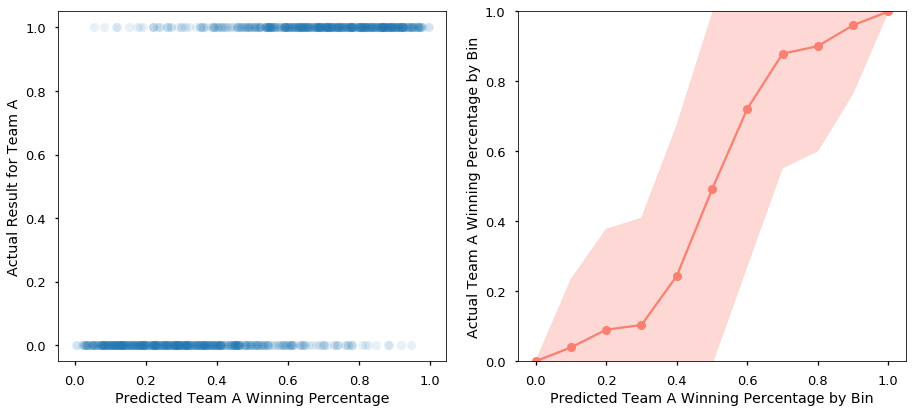

In [228]:
sns.set_context('talk')
f, axes = plt.subplots(1, 2, figsize=(13, 6))
ax = axes[0]
ax.plot(winloss_with_dup['predicted'], winloss_with_dup['Team A Wins'], 'o', alpha=0.1)
ax.set_ylabel('Actual Result for Team A')
ax.set_xlabel('Predicted Team A Winning Percentage')

ax = axes[1]
ax.plot(binned['Team A Wins'], 'o-', color='salmon')
ax.fill_between(binned.index, binnedlo['Team A Wins'], binnedhi['Team A Wins'], alpha=0.3, color='salmon')
ax.set_ylim([0, 1])
ax.set_ylabel('Actual Team A Winning Percentage by Bin')
ax.set_xlabel('Predicted Team A Winning Percentage by Bin')
plt.tight_layout()

In [229]:
team_log_loss = winloss_with_dup.groupby('Team A').apply(
    lambda x: log_loss(x['Team A Wins'].astype('int'), x['predicted'], labels=[0, 1]))

In [230]:
team_accuracy = winloss_with_dup.groupby('Team A').apply(
    lambda x: accuracy_score(x['Team A Wins'].astype('int'), np.round(x['predicted'])))

In [231]:
sns.distplot(team_accuracy, kde=False, bins=15)

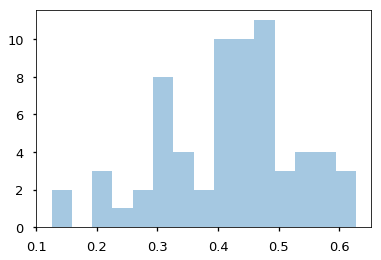

In [232]:
sns.distplot(team_log_loss, kde=False, bins=15)

In [233]:
log_loss(winloss['Team A Wins'].astype('int'), winloss['predicted'])

0.42587708033559751

In [234]:
accuracy_score(winloss['Team A Wins'].astype('int'), np.round(winloss['predicted']))

0.84099616858237547

In [246]:
def inspect(full_outcomes, team_name):
    index = full_outcomes['Team A'] == team_name
    outcomes_index = full_outcomes[index]
    return outcomes_index.drop(['divname', 'Index A', 'Index B', 'predBin'], axis=1)

In [249]:
ins = inspect(winloss_with_dup, 'Injustice League')
ins

Team A                             Team B  Team A Wins  \
180  Injustice League                         Turtle Boy         True   
181  Injustice League                   A Lil Bit Sticky         True   
182  Injustice League             Jack's Abby HAOS Lager         True   
183  Injustice League                    Hipster Kitties         True   
184  Injustice League                    Moose Lightning         True   
185  Injustice League                              Tubbs         True   
186  Injustice League                        Booooooosh!         True   
187  Injustice League  Live Poultry, Fresh Killed (LPFK)         True   
188  Injustice League                         Zerg Rush!        False   
189  Injustice League                           Dominion         True   
190  Injustice League                              Fetch         True   
191  Injustice League                                BBN         True   
192  Injustice League                    Hipster Kitties         True   
193  Injustice League                    Rogues' Gallery         True   
194  Injustice League                       Puddingstone         True   

         Div A      Div B  predicted  
180  4/3 Div 2  4/3 Div 1   0.620238  
181  4/3 Div 2  4/3 Div 2   0.909862  
182  4/3 Div 2  4/3 Div 2   0.620048  
183  4/3 Div 2  4/3 Div 2   0.965496  
184  4/3 Div 2  4/3 Div 2   0.905956  
185  4/3 Div 2  4/3 Div 2   0.968941  
186  4/3 Div 2  4/3 Div 2   0.884513  
187  4/3 Div 2  4/3 Div 1   0.710248  
188  4/3 Div 2  4/3 Div 1   0.273526  
189  4/3 Div 2  4/3 Div 2   0.856983  
190  4/3 Div 2  4/3 Div 2   0.892082  
191  4/3 Div 2  4/3 Div 1   0.657564  
192  4/3 Div 2  4/3 Div 2   0.965496  
193  4/3 Div 2  4/3 Div 2   0.868640  
194  4/3 Div 2  4/3 Div 2   0.602423

In [250]:
ins = inspect(winloss_with_dup, 'Gothrilla')
ins

Team A                             Team B  Team A Wins      Div A  \
14  Gothrilla                               AHOC        False  4/3 Div 1   
15  Gothrilla                           Swingers        False  4/3 Div 1   
16  Gothrilla                          FlowChart         True  4/3 Div 1   
17  Gothrilla              Hucky McThrowandcatch         True  4/3 Div 1   
18  Gothrilla               SnakeCountryBromance        False  4/3 Div 1   
19  Gothrilla                         Zerg Rush!        False  4/3 Div 1   
20  Gothrilla                        GrassBurner         True  4/3 Div 1   
21  Gothrilla                         Turtle Boy         True  4/3 Div 1   
22  Gothrilla  Live Poultry, Fresh Killed (LPFK)         True  4/3 Div 1   
23  Gothrilla                           Upstream         True  4/3 Div 1   
24  Gothrilla  Live Poultry, Fresh Killed (LPFK)         True  4/3 Div 1   
25  Gothrilla                          TuneSquad         True  4/3 Div 1   
26  Gothrilla                                BBN         True  4/3 Div 1   
27  Gothrilla                           Swingers         True  4/3 Div 1   
28  Gothrilla                         Zerg Rush!         True  4/3 Div 1   
29  Gothrilla                        GrassBurner        False  4/3 Div 1   
30  Gothrilla                     Shake and Bake         True  4/3 Div 1   

        Div B  predicted  
14  4/3 Div 1   0.244296  
15  4/3 Div 1   0.741555  
16  4/3 Div 1   0.535600  
17  5/2 Div 2   0.918867  
18  5/2 Div 1   0.350327  
19  4/3 Div 1   0.482876  
20  4/3 Div 1   0.702635  
21  4/3 Div 1   0.810360  
22  4/3 Div 1   0.868787  
23  4/3 Div 2   0.806018  
24  4/3 Div 1   0.868787  
25  4/3 Div 1   0.766101  
26  4/3 Div 1   0.833633  
27  4/3 Div 1   0.741555  
28  4/3 Div 1   0.482876  
29  4/3 Div 1   0.702635  
30  5/2 Div 1   0.836028

In [251]:
ins = inspect(winloss_with_dup, 'SnakeCountryBromance')
ins

Team A          Team B  Team A Wins      Div A      Div B  \
666  SnakeCountryBromance  Shake and Bake         True  5/2 Div 1  5/2 Div 1   
667  SnakeCountryBromance      Zerg Rush!         True  5/2 Div 1  4/3 Div 1   
668  SnakeCountryBromance     GrassBurner         True  5/2 Div 1  4/3 Div 1   
669  SnakeCountryBromance       Gothrilla         True  5/2 Div 1  4/3 Div 1   
670  SnakeCountryBromance       SHRedline         True  5/2 Div 1  5/2 Div 2   

     predicted  
666   0.900348  
667   0.634107  
668   0.808606  
669   0.649673  
670   0.964811

In [252]:
ins = inspect(winloss_with_dup, 'Upstream')
ins

Team A                                      Team B  Team A Wins  \
154  Upstream                           Store Bought Dirt         True   
155  Upstream                           Too Drunk to Fail         True   
156  Upstream                      Jack's Abby HAOS Lager        False   
157  Upstream                           Lady and the BAMF         True   
158  Upstream                             Moose Lightning         True   
159  Upstream                                        JHOP         True   
160  Upstream           Live Poultry, Fresh Killed (LPFK)        False   
161  Upstream                   Underwater Monkey Cowboys         True   
162  Upstream                                   SHRedline         True   
163  Upstream                                  Turtle Boy         True   
164  Upstream                                   Disc Envy         True   
165  Upstream                                       Toads         True   
166  Upstream                                Puddingstone         True   
167  Upstream                                        AHOC        False   
168  Upstream                      Jack's Abby HAOS Lager        False   
169  Upstream                                   Gothrilla        False   
170  Upstream                                        JHOP         True   
171  Upstream                           TuneSquad Squared         True   
172  Upstream  License to Kilt (fka Scoobers in Scotland)         True   
173  Upstream                            A Lil Bit Sticky         True   
174  Upstream                             Hipster Kitties        False   
175  Upstream                                       Tubbs         True   
176  Upstream                                   FlowChart         True   
177  Upstream                           Store Bought Dirt         True   
178  Upstream                                  Nerd Alert         True   
179  Upstream                                       Fetch         True   

         Div A      Div B  predicted  
154  4/3 Div 2  4/3 Div 2   0.820983  
155  4/3 Div 2  4/3 Div 3   0.794674  
156  4/3 Div 2  4/3 Div 2   0.509748  
157  4/3 Div 2  4/3 Div 2   0.923329  
158  4/3 Div 2  4/3 Div 2   0.861439  
159  4/3 Div 2  4/3 Div 2   0.744435  
160  4/3 Div 2  4/3 Div 1   0.609701  
161  4/3 Div 2  4/3 Div 3   0.952862  
162  4/3 Div 2  5/2 Div 2   0.781286  
163  4/3 Div 2  4/3 Div 1   0.509122  
164  4/3 Div 2  4/3 Div 2   0.809120  
165  4/3 Div 2  4/3 Div 2   0.771542  
166  4/3 Div 2  4/3 Div 2   0.487821  
167  4/3 Div 2  4/3 Div 1   0.070357  
168  4/3 Div 2  4/3 Div 2   0.509748  
169  4/3 Div 2  4/3 Div 1   0.193982  
170  4/3 Div 2  4/3 Div 2   0.744435  
171  4/3 Div 2  4/3 Div 2   0.974466  
172  4/3 Div 2  4/3 Div 2   0.666437  
173  4/3 Div 2  4/3 Div 2   0.866187  
174  4/3 Div 2  4/3 Div 2   0.946808  
175  4/3 Div 2  4/3 Div 2   0.952414  
176  4/3 Div 2  4/3 Div 1   0.220171  
177  4/3 Div 2  4/3 Div 2   0.820983  
178  4/3 Div 2  4/3 Div 2   0.889087  
179  4/3 Div 2  4/3 Div 2   0.840882

In [253]:
ins = inspect(winloss_with_dup, 'Store Bought Dirt')
ins

Team A                                      Team B  \
344  Store Bought Dirt                                    Upstream   
345  Store Bought Dirt                                      M.O.B.   
346  Store Bought Dirt                                   Disc Envy   
347  Store Bought Dirt                   Underwater Monkey Cowboys   
348  Store Bought Dirt                                       Toads   
349  Store Bought Dirt                                        JHOP   
350  Store Bought Dirt                                  Nerd Alert   
351  Store Bought Dirt                                    Dominion   
352  Store Bought Dirt                                       Fetch   
353  Store Bought Dirt                          Flaming Croissants   
354  Store Bought Dirt  License to Kilt (fka Scoobers in Scotland)   
355  Store Bought Dirt                             Rubs The Duckie   
356  Store Bought Dirt                      Jack's Abby HAOS Lager   
357  Store Bought Dirt                                   Top Shelf   
358  Store Bought Dirt                                       Tubbs   
359  Store Bought Dirt                             Hipster Kitties   
360  Store Bought Dirt                                       Toads   
361  Store Bought Dirt                                   123 Trap!   
362  Store Bought Dirt                                Puddingstone   
363  Store Bought Dirt                           TuneSquad Squared   
364  Store Bought Dirt                         Stack to the Future   
365  Store Bought Dirt                            A Lil Bit Sticky   
366  Store Bought Dirt                                Flying Salsa   
367  Store Bought Dirt                                    Upstream   

     Team A Wins      Div A      Div B  predicted  
344        False  4/3 Div 2  4/3 Div 2   0.179017  
345         True  4/3 Div 2  5/2 Div 3   0.876757  
346        False  4/3 Div 2  4/3 Div 2   0.484520  
347         True  4/3 Div 2  4/3 Div 3   0.809805  
348         True  4/3 Div 2  4/3 Div 2   0.426303  
349        False  4/3 Div 2  4/3 Div 2   0.390755  
350         True  4/3 Div 2  4/3 Div 2   0.634497  
351        False  4/3 Div 2  4/3 Div 2   0.466981  
352         True  4/3 Div 2  4/3 Div 2   0.538184  
353         True  4/3 Div 2  4/3 Div 2   0.352378  
354        False  4/3 Div 2  4/3 Div 2   0.307257  
355        False  4/3 Div 2  4/3 Div 2   0.342689  
356        False  4/3 Div 2  4/3 Div 2   0.189629  
357         True  4/3 Div 2  4/3 Div 3   0.835080  
358         True  4/3 Div 2  4/3 Div 2   0.808294  
359         True  4/3 Div 2  4/3 Div 2   0.790741  
360         True  4/3 Div 2  4/3 Div 2   0.426303  
361         True  4/3 Div 2  4/3 Div 3   0.904091  
362        False  4/3 Div 2  4/3 Div 2   0.171864  
363         True  4/3 Div 2  4/3 Div 2   0.888164  
364        False  4/3 Div 2  4/3 Div 3   0.763084  
365        False  4/3 Div 2  4/3 Div 2   0.587225  
366         True  4/3 Div 2  5/2 Div 3   0.569268  
367        False  4/3 Div 2  4/3 Div 2   0.179017